In [1]:
import xarray as xr
import numpy as np 
import os
import types
import matplotlib.pyplot as plt
import pandas as pd

from src.utils import util_cesm
from src import config_cesm
from src.models import models_util

reference_grid = util_cesm.generate_sps_grid()

def load_globals(module):
    """
    Load all global variables declared in a module as a dictionary.
    
    Parameters:
        module (module): The loaded Python module.
    
    Returns:
        dict: A dictionary containing global variables from the module.
    """
    return {
        name: value
        for name, value in vars(module).items()
        if not name.startswith("__") and not isinstance(value, types.ModuleType) and not callable(value)
    }

def get_ensemble_members_and_time_coords(data_split_settings, split):
    if data_split_settings["split_by"] == "ensemble_member":
        ensemble_members = data_split_settings[split]
        time_coords = data_split_settings["time_range"]
    elif data_split_settings["split_by"] == "time":
        ensemble_members = data_split_settings["member_ids"]
        time_coords = data_split_settings[split]

    return ensemble_members, time_coords


def broadcast_climatology_like(data_split_settings, da):
    """
    Param:
        dict            this should have the name of the data_settings which specifies the climatology 
        xr.DataArray    prediction-like array that you want to broadcast climatology 
    
    Returns:
        xr.DataArray    climatology broadcasted
    """

    icefrac_mean = xr.open_dataset(f"{config_cesm.PROCESSED_DATA_DIRECTORY}/normalized_inputs/{data_split_settings["name"]}/icefrac_mean.nc").icefrac
    
    def calculate_month(start_month, lead_time):
        return (start_month + lead_time - 2) % 12 + 1

    pred_months = xr.apply_ufunc(
        calculate_month,
        da["start_prediction_month"].dt.month,
        da["lead_time"],
        vectorize=True,
        dask="allowed",
        output_dtypes=[int],
    )

    climatology_broadcasted = icefrac_mean.sel(month=pred_months).broadcast_like(da).drop_vars("month")

    return climatology_broadcasted


def add_climatology(da, climatology_broadcasted, clip=True):
    """
    Param:
        (xr.DataArray)  array of anomalies
        (xr.DataArray)  array of climatology that is the same shape as da
                        note: to do this you can run broadcast_climatology_like
        (bool)          possibly clip the anomalies to 

    Returns:
        (xr.DataArray)
    """
    # Add climatology back to the anomalies
    absolute_da = da + climatology_broadcasted

    # Clip the resulting values to [0, 1]
    if clip: absolute_da = absolute_da.clip(0, 1)

    return absolute_da

def remove_climatology(da, climatology_broadcasted):
    return da - climatology_broadcasted


def load_model_predictions(config, nn_ens_avg=True, climatology_broadcasted=None, add_climatology_to_anomaly=True):
    """
    If the config specifies that the predictions are anomalies, then the climatology is added back
    WITH clipping of unphysical values (e.g., if anomaly prediction is -0.5 but the climatology for that
    cell is 0.3, then the resulting value will be clipped to 0).
    """
    output_dir = os.path.join(config_cesm.PREDICTIONS_DIRECTORY, config["EXPERIMENT_NAME"])
    output_path = os.path.join(output_dir, f"{config["MODEL"]}_{config["CHECKPOINT_TO_EVALUATE"]}_predictions.nc")
    predictions = xr.open_dataset(output_path).predictions 

    if config["TARGET_CONFIG"]["predict_anom"] and add_climatology_to_anomaly:
        if climatology_broadcasted is None:
            raise ValueError("need to supply climatology_broadcasted if add_climatology_to_anomaly is true!")

        predictions = add_climatology(predictions, climatology_broadcasted)

    if nn_ens_avg and ("nn_member_id" in predictions.dims): 
        predictions = predictions.mean("nn_member_id")

    return predictions 

def load_targets(config, split, climatology_broadcasted=None, add_climatology_to_anomaly=True):
    ensemble_members, time_coords = get_ensemble_members_and_time_coords(config["DATA_SPLIT_SETTINGS"], split)
    data_dir = os.path.join(config_cesm.PROCESSED_DATA_DIRECTORY, "data_pairs", config["DATA_SPLIT_SETTINGS"]["name"])
    ds_list = []
    for member_id in ensemble_members:
        ds = xr.open_dataset(os.path.join(data_dir, f"targets_member_{member_id}.nc")).data.load()
        ds_list.append(ds)

    targets = xr.concat(ds_list, dim="member_id").sel(start_prediction_month=time_coords)
    targets = targets.transpose("start_prediction_month", "member_id", "lead_time", "y", "x")

    if config["TARGET_CONFIG"]["predict_anom"] and add_climatology_to_anomaly:
        if climatology_broadcasted is None:
            raise ValueError("need to supply climatology_broadcasted if add_climatology_to_anomaly is true!")

        targets = add_climatology(targets, climatology_broadcasted)

    return targets

def get_broadcast_climatology(config, split):
    ensemble_members, time_coords = get_ensemble_members_and_time_coords(config["DATA_SPLIT_SETTINGS"], split)

    empty_predictions_da = models_util.generate_empty_predictions_ds(reference_grid, 
            time_coords, 
            ensemble_members,
            config["MAX_LEAD_MONTHS"], 80, 80).predictions 
    
    return broadcast_climatology_like(config["DATA_SPLIT_SETTINGS"], empty_predictions_da)

def aggregate_acc(acc, dim):
    if dim == ("x", "y"):
        acc = acc.mean('member_id').groupby("start_prediction_month.month").mean("start_prediction_month")
    else: 
        raise ValueError()
        
    # roll in lead time so that it gets lined up
    return xr.concat(
        [acc.roll(month=int(lt - 1), roll_coords=False).sel(lead_time=lt) for lt in acc.lead_time.values],
        dim="lead_time"
    )


def calculate_acc(pred_anom, truth_anom, aggregate, dim="start_prediction_month"):
    """
    Calculate the Anomaly Correlation Coefficient (ACC) between predictions and truth.

    Parameters:
    - pred_anom  (xr.DataArray): Predictions (absolute, not anomalies) 
    - truth_anom (xr.DataArray): True anomalies with dimensions including `dim`.
    - aggregate          (bool): if True, mean-aggregate down to dims (month, lead_time) 
    - dim                 (str): The dimension over which to calculate the ACC.
                                 Default is "start_prediction_month".
    
    Returns:
    - xr.DataArray: ACC values with dimensions remaining after collapsing `dim`.
    """
    # Ensure dimensions match
    if pred_anom.dims != truth_anom.dims:
        raise ValueError("Predictions and truth must have the same dimensions.")

    acc = xr.cov(pred_anom, truth_anom, dim=dim) / (pred_anom.std(dim=dim) * truth_anom.std(dim=dim))

    if aggregate:
        acc = aggregate_acc(acc, dim)

    return acc

class ModelDiagnostics():
    """
    This wrapper class is used to evaluate the model predictions for a given experiment configuration.
    """

    def __init__(self, config, nn_ens_avg, climatology_broadcasted: xr.DataArray = None):
        """
        Expected: 
            config (dict)       dictionary of the experiment configuration 
            nn_ens_avg (bool)   if the predictions include multiple neural net ensemble members, 
                                this averages the predictions if set to true. 

        Optional:
            climatology_broadcasted (xr.DataArray)  climatology broadcasted to the same shape \
                as the model predictions. If not provided, then it will be loaded according to \
                config. Note that this can take a long time, so if possible it is preferable \
                to supply the climatology_broadcasted array.
        """

        self.config = config
        self.nn_ens_avg = nn_ens_avg 

        # load climatology if not provided
        if climatology_broadcasted is None:
            self.climatology_broadcasted = get_broadcast_climatology(config, "test")
        else:
            self.climatology_broadcasted = climatology_broadcasted

        # load predictions and targets into xr.DataArray 
        self.predictions = self.load_model_predictions_wrapper()
        self.predictions_anomaly = remove_climatology(self.predictions, self.climatology_broadcasted)

        self.targets = self.load_targets_wrapper()
        self.targets_anomaly = remove_climatology(self.targets, self.climatology_broadcasted)

        # calculate linear difference
        self.diff = self.predictions - self.targets
        
    def load_model_predictions_wrapper(self):
        return load_model_predictions(self.config, self.nn_ens_avg, climatology_broadcasted=self.climatology_broadcasted) 

    def load_targets_wrapper(self):
        return load_targets(self.config, "test", climatology_broadcasted=self.climatology_broadcasted)

    def calculate_acc(self, aggregate, dim):
        return calculate_acc(self.predictions_anomaly, self.targets_anomaly, aggregate, dim)

In [2]:
from src.experiment_configs.exp1_inputs import input2 
from src.experiment_configs.exp1_inputs import input3a
from src.experiment_configs.exp1_inputs import input3b
from src.experiment_configs.exp1_inputs import input3c
from src.experiment_configs.exp1_inputs import input4 

input2_cdict = load_globals(input2)
climatology_broadcast = get_broadcast_climatology(input2_cdict, "test")

In [3]:
import gc

cdicts = {
    "input2": input2, 
    "input3a": input3a, 
    "input3b": input3b, 
    "input3c": input3c, 
    "input4": input4
}

targets = load_targets(input2_cdict, "test", add_climatology_to_anomaly=False)

acc = {}
acc_agg = {}

num_nn_ens_members = 5 
for key, config in cdicts.items():
    print(f"computing ACC for {key}")
    cdict = load_globals(config) 
    pred = load_model_predictions(cdict, nn_ens_avg=False, climatology_broadcasted=None, 
                                    add_climatology_to_anomaly=False)

    acc_temp_list = []
    for i in range(num_nn_ens_members): 
        acc_temp = calculate_acc(pred.isel(nn_member_id=i), 
                            targets, dim=("x","y"), aggregate=False)
        acc_temp_list.append(acc_temp)
    acc[key] = xr.concat(acc_temp_list, dim="nn_member_id")
    acc_agg[key] = aggregate_acc(acc[key], dim=("x","y"))



computing ACC for input2
computing ACC for input3a
computing ACC for input3b


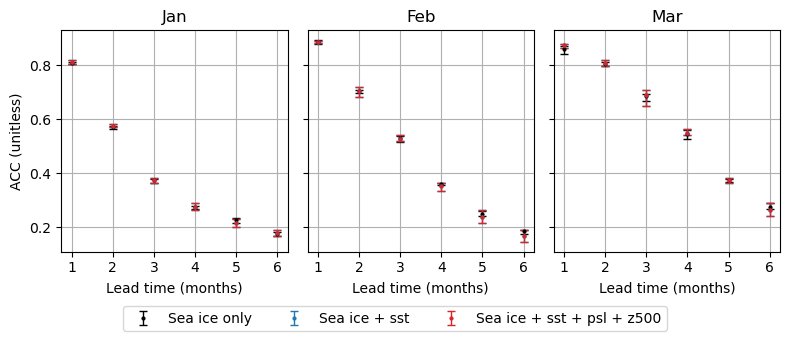

In [50]:
fig, axs = plt.subplots(nrows=1, ncols=3, figsize=(8, 3.5), sharex=True, sharey=True)

x = np.arange(1, 7)
months = ["Jan", "Feb", "Mar"]

# Store one copy of handles for the legend
legend_handles = []
legend_labels = []

for i, month in enumerate([1, 2, 3]):
    mean2 = acc_agg["input2"].sel(month=month).mean("nn_member_id")
    min2 = acc_agg["input2"].sel(month=month).min("nn_member_id")
    max2 = acc_agg["input2"].sel(month=month).max("nn_member_id")
    
    mean3 = acc_agg["input3a"].sel(month=month).mean("nn_member_id")
    min3 = acc_agg["input3a"].sel(month=month).min("nn_member_id")
    max3 = acc_agg["input3a"].sel(month=month).max("nn_member_id")
    
    mean4 = acc_agg["input4"].sel(month=month).mean("nn_member_id")
    min4 = acc_agg["input4"].sel(month=month).min("nn_member_id")
    max4 = acc_agg["input4"].sel(month=month).max("nn_member_id")

    eb1 = axs[i].errorbar(x, mean2, 
                          yerr=[mean2 - min2, max2 - mean2], 
                          fmt='o', color='k', label="Sea ice only",
                          capsize=3, markersize=2, elinewidth=1)

    eb2 = axs[i].errorbar(x, mean3, 
                          yerr=[mean3 - min3, max3 - mean3], 
                          fmt='o', color='tab:blue', label="Sea ice + sst",
                          capsize=3, markersize=2, elinewidth=1)

    eb3 = axs[i].errorbar(x, mean4, 
                          yerr=[mean4 - min4, max4 - mean4], 
                          fmt='o', color='tab:red', label="Sea ice + sst + psl + z500",
                          capsize=3, markersize=2, elinewidth=1)

    axs[i].grid()
    axs[i].set_xticks(x)
    axs[i].set_xlabel("Lead time (months)")
    axs[i].set_title(months[i])

axs[0].set_ylabel("ACC (unitless)")

handles = [eb1, eb2, eb3]
labels = [h.get_label() for h in handles]

fig.tight_layout(rect=[0, 0.1, 1, 1])
fig.legend(handles, labels, loc="lower center", ncol=3, bbox_to_anchor=(0.5, 0.02))

#plt.savefig("figures/cesm/exp1_ACC_diff_inputs_with_error_points.jpg", dpi=300, bbox_inches="tight")


/tmp/ipykernel_26745/2104821245.py:26: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


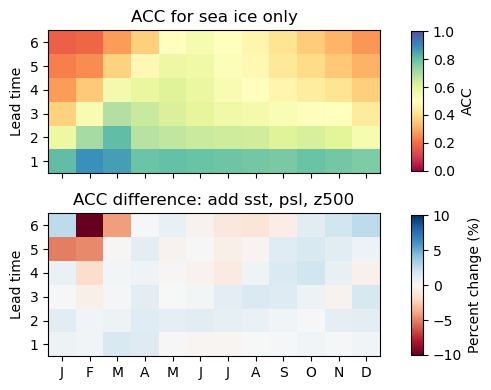

In [87]:

fig, axs = plt.subplots(nrows=2, ncols=1, figsize=(4,4), sharex=True)

x = np.arange(13)
y = np.arange(7)
x_centers = (x[:-1] + x[1:]) / 2
y_centers = (y[:-1] + y[1:]) / 2

acc_input2 = acc_agg["input2"].mean("nn_member_id")
acc_input4 = acc_agg["input4"].mean("nn_member_id")

cax = axs[0].pcolormesh(x, y, acc_input2, cmap='Spectral', shading='flat', vmin=0, vmax=1)
axs[0].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[0].set_ylabel("Lead time")
axs[0].set_title(f"ACC for sea ice only")

cax2 = axs[1].pcolormesh(x, y, 100 * (acc_input4 - acc_input2) / acc_input2, cmap='RdBu', shading='flat', vmin=-10, vmax=10)
axs[1].set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])
axs[1].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[1].set_ylabel("Lead time")
axs[1].set_title("ACC difference: add sst, psl, z500")

cbar_ax = fig.add_axes([1.04, 0.56, 0.03, 0.35])
cbar_ax2 = fig.add_axes([1.04, 0.10, 0.03, 0.35])
plt.colorbar(cax, cax=cbar_ax, label=r'ACC', orientation='vertical')
plt.colorbar(cax2, cax=cbar_ax2, label=r'Percent change (%)', orientation='vertical')
plt.tight_layout()
plt.savefig("figures/cesm/exp1_ACC_diff_inputs_percent.jpg", dpi=300, bbox_inches='tight')

/tmp/ipykernel_1741/1289866336.py:33: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


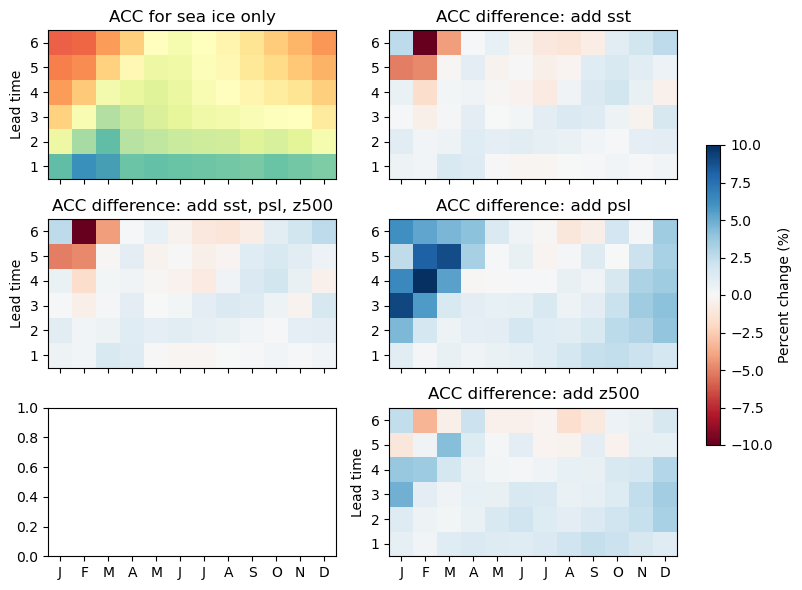

In [116]:

fig, axs = plt.subplots(nrows=3, ncols=2, figsize=(7,6), sharex=True)

x = np.arange(13)
y = np.arange(7)
x_centers = (x[:-1] + x[1:]) / 2
y_centers = (y[:-1] + y[1:]) / 2

acc_input2 = acc_agg["input2"].mean("nn_member_id")
input_added = ["sst", "psl", "z500"]

axs[0,0].pcolormesh(x, y, acc_input2, cmap='Spectral', shading='flat', vmin=0, vmax=1)
axs[0,0].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[0,0].set_ylabel("Lead time")
axs[0,0].set_title(f"ACC for sea ice only")

axs[1,0].pcolormesh(x, y, 100 * (acc_agg["input4"].mean("nn_member_id") - acc_input2) / acc_input2, 
            cmap='RdBu', shading='flat', vmin=-10, vmax=10)
axs[1,0].set_yticks(y_centers, labels=np.arange(1,7,1))
axs[1,0].set_ylabel("Lead time")
axs[1,0].set_title(f"ACC difference: add sst, psl, z500")

for i, input_config in enumerate(["input3a", "input3b", "input3c"]):
    cax = axs[i,1].pcolormesh(x, y, 100 * (acc_agg[input_config].mean("nn_member_id") - acc_input2) / acc_input2, 
            cmap='RdBu', shading='flat', vmin=-10, vmax=10)
    axs[i,1].set_xticks(x_centers, labels=["J","F","M","A","M","J","J","A","S","O","N","D"])
    axs[i,1].set_yticks(y_centers, labels=np.arange(1,7,1))
    axs[i,1].set_title(f"ACC difference: add {input_added[i]}")

axs[2,1].set_ylabel("Lead time")

cbar_ax = fig.add_axes([1.02, 0.25, 0.02, 0.5])
plt.colorbar(cax, cax=cbar_ax, label=r'Percent change (%)', orientation='vertical')
plt.tight_layout()
#plt.savefig("figures/cesm/exp1_ACC_diff_inputs_separate_percent.jpg", dpi=300, bbox_inches='tight')

0.16541651085250114 0.18486967956709124


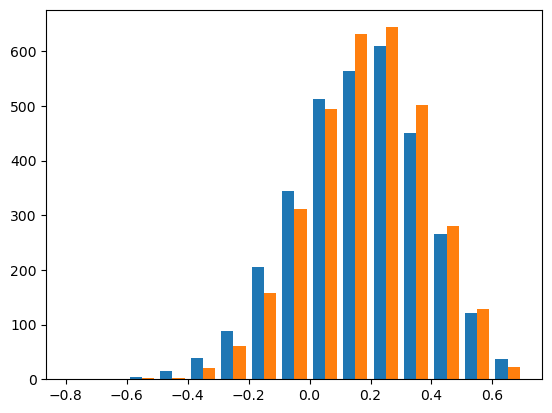

In [17]:
time_da = acc["input4"].start_prediction_month
acc_subset_2 = acc["input2"].isel(lead_time=5).where(time_da.dt.month==9, drop=True)
acc_subset_3a = acc["input3a"].isel(lead_time=5).where(time_da.dt.month==9, drop=True)
plt.hist([subset1.values.flatten(), subset2.values.flatten()], 
        bins=np.arange(-0.8, 0.8, 0.1))

print(subset1.values.mean(), subset2.values.mean())

In [33]:
pred_2 = load_model_predictions(load_globals(input2), nn_ens_avg=False, climatology_broadcasted=None, 
                                add_climatology_to_anomaly=False)
pred_3a = load_model_predictions(load_globals(input3a), nn_ens_avg=False, climatology_broadcasted=None, 
                                add_climatology_to_anomaly=False)

pred_2_subset = pred_2.isel(lead_time=5).where(time_da.dt.month==9, drop=True)
pred_3a_subset = pred_3a.isel(lead_time=5).where(time_da.dt.month==9, drop=True)

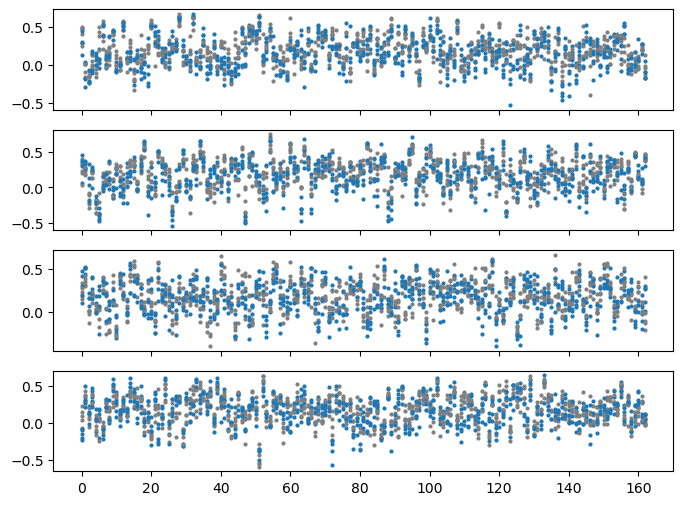

In [108]:
fig, axs = plt.subplots(nrows=4, ncols=1, figsize=(8,6), sharex=True)
for i in range(4):
    for j in range(5):
        axs[i].plot(acc_subset_2.isel(nn_member_id=j, member_id=i), marker='o', markersize=2, linewidth=0, color='grey', alpha=1)
        axs[i].plot(acc_subset_3a.isel(nn_member_id=j, member_id=i), marker='o', markersize=2, linewidth=0, color='tab:blue', alpha=1)


In [87]:
# select worst predictions
mask = np.argsort((acc_subset_2 - acc_subset_3a), axis=1) < 2
mask = np.transpose(mask, axes=[1, 2, 0])

pred_2_worst = pred_2_subset.values.reshape(-1, 80, 80)[mask.values.flatten()]
pred_3a_worst = pred_3a_subset.values.reshape(-1, 80, 80)[mask.values.flatten()]

targets_subset = targets.isel(lead_time=5).where(time_da.dt.month==9, drop=True)
targets_worst = targets_subset.values.reshape(-1, 80, 80)[np.any(mask.values, axis=2).flatten()]


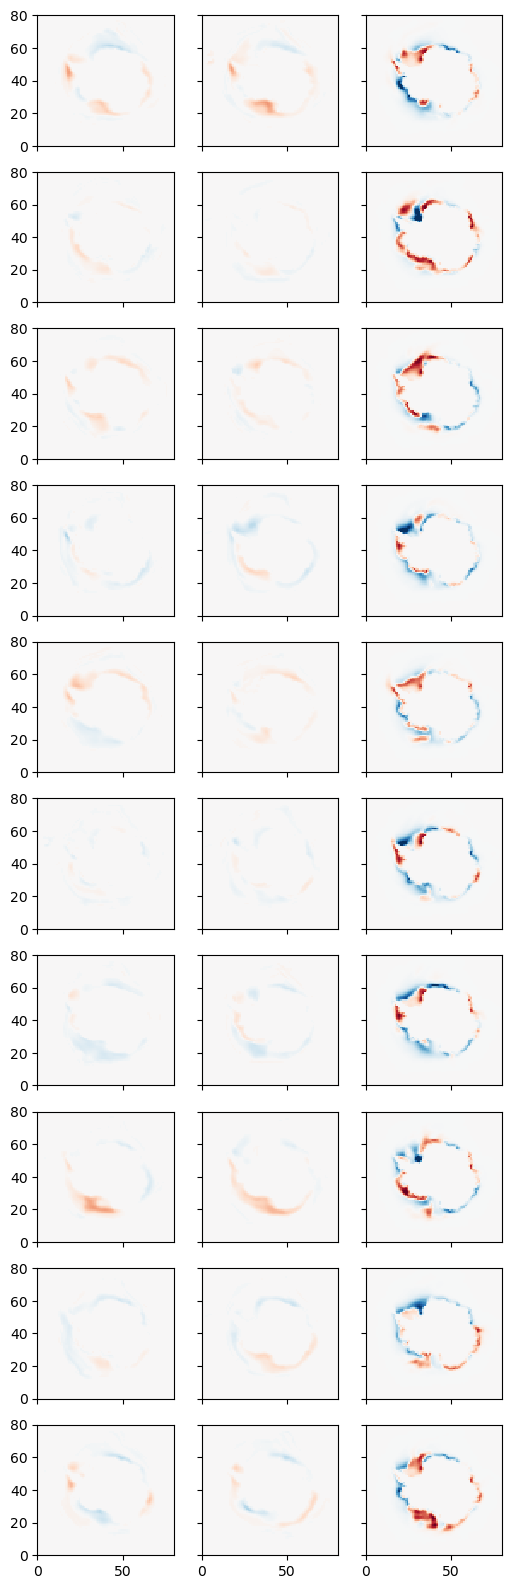

In [88]:

fig, axs = plt.subplots(nrows=10, ncols=3, figsize=(6, 20), sharex=True, sharey=True)
for i in range(10):
    axs[i, 0].pcolormesh(pred_2_worst[i], vmin=-0.5, vmax=0.5, cmap="RdBu_r")
    axs[i, 1].pcolormesh(pred_3a_worst[i], vmin=-0.5, vmax=0.5, cmap="RdBu_r")
    axs[i, 2].pcolormesh(targets_worst[i], vmin=-0.5, vmax=0.5, cmap="RdBu_r")

what do the best predictions look like?

In [111]:
np.argsort()

<xarray.DataArray (nn_member_id: 5, start_prediction_month: 163, member_id: 4)> Size: 26kB
array([[[ 0.40753008,  0.40345926,  0.33265562, -0.0623588 ],
        [ 0.01420987,  0.27709487,  0.34661358,  0.29021221],
        [-0.1479318 , -0.23804077,  0.01629402,  0.12283135],
        ...,
        [ 0.11721251,  0.14748108,  0.23551292, -0.01345814],
        [ 0.20099346,  0.04601576,  0.07828165,  0.29613247],
        [-0.13583135,  0.45996945,  0.40577884,  0.11749977]],

       [[ 0.5001534 ,  0.19898957,  0.23792673,  0.09669823],
        [-0.08692126,  0.23091075,  0.31900218,  0.36423844],
        [-0.13373057, -0.28848988, -0.12466558,  0.05411897],
        ...,
        [ 0.04850172,  0.12826347,  0.13839038,  0.1497669 ],
        [ 0.23859237,  0.09318756,  0.12027232,  0.27108915],
        [-0.0335567 ,  0.3699474 , -0.01114848,  0.05508943]],

       [[ 0.29494904,  0.35781772,  0.18740773,  0.22718982],
        [-0.15504082,  0.18008034,  0.41950555,  0.37517928],
        [-0.15187322, -0.08395574,  0.0154887 ,  0.0880604 ],
        ...,
        [-0.05763385,  0.11957012,  0.30839344,  0.20893576],
        [ 0.27288471,  0.07170309,  0.12231883,  0.28375335],
        [-0.01248902,  0.38577171, -0.10024972,  0.07450637]],

       [[ 0.49278842,  0.03778303,  0.15359299,  0.15269085],
        [ 0.01068145,  0.16718069,  0.30377381,  0.3097129 ],
        [-0.16098673, -0.10558157, -0.02575207,  0.20039341],
        ...,
        [-0.03416818,  0.11912254,  0.23654394,  0.20243746],
        [ 0.19454559, -0.02200215, -0.01323192,  0.36240199],
        [ 0.1347263 ,  0.44769761, -0.20937922, -0.00773887]],

       [[ 0.25639874,  0.22622882,  0.27906574,  0.03537044],
        [ 0.02053532,  0.28232758,  0.37928005,  0.43645503],
        [-0.23072951, -0.09323367,  0.01408883, -0.05386741],
        ...,
        [-0.01869236,  0.18461464,  0.35357295,  0.09392319],
        [ 0.26464133, -0.08629379,  0.017321  ,  0.04699428],
        [-0.16997015,  0.46593146, -0.12604524, -0.02647922]]])
Coordinates:
  * start_prediction_month  (start_prediction_month) datetime64[ns] 1kB 1851-...
  * member_id               (member_id) <U11 176B 'r2i1251p1f1' ... 'r3i1041p...
  * nn_member_id            (nn_member_id) int64 40B 0 1 2 3 4
    lead_time               int64 8B 6